#Q.1


In [114]:
## Import necessary libarraies
import numpy as np
from sklearn.datasets import load_iris
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [115]:
## Define Helper Functions for  calculating Entropy and Information Gain
def entropy(y):
    """Calculate the entropy of a dataset."""
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

def information_gain(X, y, feature_index):
    """Calculate information gain of a dataset when splitting on a particular feature."""
    # Calculate the entropy of the entire dataset
    total_entropy = entropy(y)

    # Get unique values of the feature for splitting
    feature_values = np.unique(X[:, feature_index])

    # Calculate the weighted entropy after splitting on this feature
    weighted_entropy = 0
    for value in feature_values:
        # Split data based on the feature value
        subset_y = y[X[:, feature_index] == value]

        # Calculate the proportion of this subset in the original dataset
        subset_weight = len(subset_y) / len(y)

        # Add the weighted entropy of the subset
        weighted_entropy += subset_weight * entropy(subset_y)

    # Information Gain is the reduction in entropy
    return total_entropy - weighted_entropy

In [119]:
##: Define the Decision Tree Classifier
## The decision tree will be built recursively.
# It will decide on the best feature to split based on Information Gain and then recursively split until it either reaches a stopping condition
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Stopping conditions
        if len(np.unique(y)) == 1:
            # All labels are the same, return leaf node
            return {'label': y[0]}

        if len(X) == 0 or (self.max_depth and depth >= self.max_depth):
            # No data or max depth reached, return most common label
            return {'label': Counter(y).most_common(1)[0][0]}

        # Find the feature with the highest information gain
        best_gain = -1
        best_feature = None
        for feature_index in range(X.shape[1]):
            gain = information_gain(X, y, feature_index)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index

        if best_gain == 0:
            return {'label': Counter(y).most_common(1)[0][0]}

        # Split the dataset based on the best feature
        tree = {'feature_index': best_feature, 'branches': {}}
        feature_values = np.unique(X[:, best_feature])

        for value in feature_values:
            subset_X = X[X[:, best_feature] == value]
            subset_y = y[X[:, best_feature] == value]

            # Recursively build subtrees
            tree['branches'][value] = self._build_tree(subset_X, subset_y, depth + 1)

        return tree

    def predict(self, X):
        return [self._predict_single(x) for x in X]

    def _predict_single(self, x):
        node = self.tree
        while 'label' not in node:
            feature_value = x[node['feature_index']]
            node = node['branches'].get(feature_value)
            if node is None:
                return None  # If feature value is not found in the tree (edge case)
        return node['label']

In [121]:
## Train and Test the Decision Tree Classifier

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = tree.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 68.89%


#Q.2

In [122]:
# Import Libraries
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [124]:
## Define the Random Forest Classes with methods to fit the model and make predictions.
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, max_features=None):
        self.n_estimators = n_estimators  # Number of trees
        self.max_depth = max_depth  # Max depth for decision trees
        self.max_features = max_features  # Max features to consider for each split
        self.trees = []  # List to store the trained trees

    def fit(self, X, y):
        """Fit the Random Forest model by training multiple decision trees."""
        for _ in range(self.n_estimators):
            # Bootstrap sampling: create a random sample of the data with replacement
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Initialize the decision tree and fit it to the sampled data
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(X_sample, y_sample)

            # Append the trained tree to the list
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        """Generate a bootstrap sample of the data."""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        """Make predictions using majority voting from all trees."""
        # Get predictions from all trees
        tree_preds = np.array([tree.predict(X) for tree in self.trees])

        # Majority vote: each tree votes for a class, the most common class is selected
        majority_votes = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds.T]
        return np.array(majority_votes)

In [126]:
##  Load the Dataset
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [128]:
## Train the Random Forest Model
# Initialize and train the Random Forest classifier
rf = RandomForest(n_estimators=100, max_depth=5, max_features=2)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

In [129]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


#Q.3

In [ ]:
#Import required libraries
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

In [ ]:
## Create the k-Fold Cross-Validation Function

def k_fold_cross_validation(X, y, k):
    n_samples = len(y)
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Shuffle the indices to ensure randomness

    folds = []
    for i in range(k):
        start = i * fold_size
        end = start + fold_size
        folds.append(indices[start:end])

    results = []

    for i in range(k):
        # Create training and validation sets
        validation_indices = folds[i]
        training_indices = np.concatenate([folds[j] for j in range(k) if j != i])

        X_train, X_val = X[training_indices], X[validation_indices]
        y_train, y_val = y[training_indices], y[validation_indices]

        # Train Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Validate the model
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        results.append(mse)

    # Return the mean MSE across all folds
    return np.mean(results)

In [ ]:
## Test the k-Fold Cross-Validation with Linear Regression
# Generate a synthetic regression dataset
X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

# Perform 5-fold cross-validation
k = 5
mean_mse = k_fold_cross_validation(X, y, k)

# Print the result
print(f"Mean MSE across {k} folds: {mean_mse:.4f}")

Mean MSE across 5 folds: 0.0099


#Q.4


In [ ]:
## Import libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
##Define the Sigmoid and Cost Function
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function for binary classification (Log Loss)
def compute_cost(y, y_pred):
    m = len(y)
    cost = -(1 / m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return cost

In [ ]:
##implement gradient descend for optimization
def gradient_descent(X, y, weights, learning_rate, iterations):
    m = len(y)
    for i in range(iterations):
        # Compute predictions
        z = np.dot(X, weights)
        y_pred = sigmoid(z)

        # Compute gradients
        gradient = (1 / m) * np.dot(X.T, (y_pred - y))

        # Update weights
        weights -= learning_rate * gradient

        # Optionally print cost every 100 iterations
        if i % 100 == 0:
            cost = compute_cost(y, y_pred)
            print(f"Iteration {i}: Cost {cost:.4f}")

    return weights

In [ ]:
##Train Logistic Regression Model
def logistic_regression(X, y, learning_rate=0.01, iterations=1000):
    # Initialize weights (including bias term as the first weight)
    weights = np.zeros(X.shape[1])

    # Optimize weights using gradient descent
    weights = gradient_descent(X, y, weights, learning_rate, iterations)

    return weights

In [ ]:
## Make Predictions
def predict(X, weights, threshold=0.5):
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

In [ ]:
##Test on a Binary Classification Dataset
# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)

# Add a bias column to X
X = np.c_[np.ones(X.shape[0]), X]  # Adding a column of ones for the bias term

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
learning_rate = 0.1
iterations = 1000
weights = logistic_regression(X_train, y_train, learning_rate, iterations)

# Make predictions
y_pred = predict(X_test, weights)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Iteration 0: Cost 0.6931
Iteration 100: Cost 0.3553
Iteration 200: Cost 0.3418
Iteration 300: Cost 0.3392
Iteration 400: Cost 0.3384
Iteration 500: Cost 0.3382
Iteration 600: Cost 0.3382
Iteration 700: Cost 0.3381
Iteration 800: Cost 0.3381
Iteration 900: Cost 0.3381
Accuracy: 80.00%


#Q.5


In [48]:
##Define Hinge loss function
def hinge_loss(W, X, y, C=0.1):
    # Calculate the hinge loss: L(W) = 1/2 * ||W||^2 + C * sum(max(0, 1 - y_i * (W * X_i + b)))
    margins = y * np.dot(X, W)
    loss = np.maximum(0, 1 - margins)
    return 0.5 * np.dot(W.T, W) + C * np.sum(loss)

In [49]:
## Implement the Gradient for Optimization
def compute_gradient(W, X, y, C=0.1):
    # Compute gradient of the hinge loss function with respect to W
    margins = y * np.dot(X, W)
    indicator = margins < 1
    grad_W = W - C * np.dot(X.T, indicator * y)  # Gradient update
    return grad_W

In [50]:
##  Implement the SVM Training Function
def train_svm(X, y, learning_rate=0.001, iterations=1000, C=0.1):
    # Initialize weights (W) to zeros
    W = np.zeros(X.shape[1])

    for i in range(iterations):
        # Compute the gradient
        grad_W = compute_gradient(W, X, y, C)

        # Update the weights using the gradient descent rule
        W -= learning_rate * grad_W

        # Print loss to monitor the progress
        if i % 100 == 0:
            loss = hinge_loss(W, X, y, C)
            print(f"Iteration {i}: Loss {loss:.4f}")

    return W

In [51]:
## Make Predictions Using the Trained Model
def predict(W, X):
    # Return class labels based on the sign of the decision function
    return np.sign(np.dot(X, W))

In [38]:
##  Test the SVM on the Iris Dataset (Binary Classification)
iris = load_iris()
X = iris.data
y = iris.target

# Only use the first two classes for binary classification (setosa and versicolor)
X = X[y != 2]  # Keep only rows where the class is 0 or 1 (setosa or versicolor)
y = y[y != 2]  # Remove class 2 (virginica)

# Convert labels to {-1, 1} for binary classification
y = 2 * y - 1  # Convert 0 to -1, and 1 to 1

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Feature Scaling**: Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)        # Only transform the test data (using the same scaler)

# Train the SVM with updated parameters (learning rate, regularization)
learning_rate = 0.001  # Smaller learning rate
iterations = 1000
C = 0.1  # Regularization strength
W = train_svm(X_train, y_train, learning_rate, iterations, C)

# Predict on the test set
y_pred = predict(W, X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Iteration 0: Loss 7.8186
Iteration 100: Loss 0.6017
Iteration 200: Loss 0.5114
Iteration 300: Loss 0.4987
Iteration 400: Loss 0.4952
Iteration 500: Loss 0.4924
Iteration 600: Loss 0.4901
Iteration 700: Loss 0.4884
Iteration 800: Loss 0.4870
Iteration 900: Loss 0.4858
Accuracy: 100.00%


#Q.6

In [53]:
pip install numpy pandas scikit-learn

In [71]:
##  Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [72]:
 ## Define the Gradient Boosting Classifier
 class SimpleGBM:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.tree_preds = []

    def fit(self, X, y):
        # Initialize the predictions to be the mean of the target values
        y_pred = np.mean(y) * np.ones_like(y)

        for i in range(self.n_estimators):
            # Compute residuals (errors) from current predictions
            residuals = y - y_pred

            # Fit a decision tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Make predictions with the tree
            tree_pred = tree.predict(X)

            # Update the main prediction using the learning rate
            y_pred += self.learning_rate * tree_pred

            # Store the tree and its prediction
            self.trees.append(tree)
            self.tree_preds.append(tree_pred)

    def predict(self, X):
        # Start with the initial mean prediction
        y_pred = np.mean([tree.predict(X) for tree in self.trees], axis=0)
        return y_pred

In [73]:
## Prepare the dataset (California Housing)
# Load the California housing dataset
data = fetch_california_housing()
X = data.data
y = data.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
## Train the Gradient Boosting Classifier
# Initialize and train the GBM model
gbm = SimpleGBM(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)

In [65]:
##Define the Gradient Boosting Model for Text Classification
class SimpleTextGBM:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Initialize the predictions to be the most frequent class (zero for binary or majority class for multiclass)
        y_pred = np.zeros_like(y)

        for i in range(self.n_estimators):
            # Compute residuals (errors) from current predictions (for classification, residual is negative log loss)
            residuals = y - y_pred

            # Fit a decision tree to the residuals
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Update the main prediction using the learning rate
            tree_pred = tree.predict(X)
            y_pred += self.learning_rate * tree_pred

            # Store the tree
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions using the stored trees
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)

        # Return the final predictions (rounding to the closest class)
        return np.round(y_pred).astype(int)

In [76]:
## Model evaluation.
# Make predictions on the test set
y_pred = gbm.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.350505888717002


#Q.7

In [79]:
## Required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [81]:
## Define PCA Class
class PCA_Scratch:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        # Step 1: Standardize the data (mean = 0, variance = 1)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean  # Center the data

        # Step 2: Calculate the covariance matrix
        covariance_matrix = np.cov(X_centered.T)

        # Step 3: Calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Step 4: Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues_sorted = eigenvalues[sorted_indices]
        eigenvectors_sorted = eigenvectors[:, sorted_indices]

        # Step 5: Keep the top 'n_components' eigenvectors
        self.components = eigenvectors_sorted[:, :self.n_components]
        self.explained_variance = eigenvalues_sorted[:self.n_components]

    def transform(self, X):
        # Step 6: Project the data onto the new basis (principal components)
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

In [82]:
##  Load and preprocess the MNIST dataset
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Get the data and labels
X = mnist.data.values
y = mnist.target.astype(int)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [83]:
 ## Apply PCA to reduce dimensions
 # Initialize PCA model
pca = PCA_Scratch(n_components=2)

# Fit the PCA model on the scaled data
pca.fit(X_scaled)

# Transform the data into the first two principal components
X_pca = pca.transform(X_scaled)

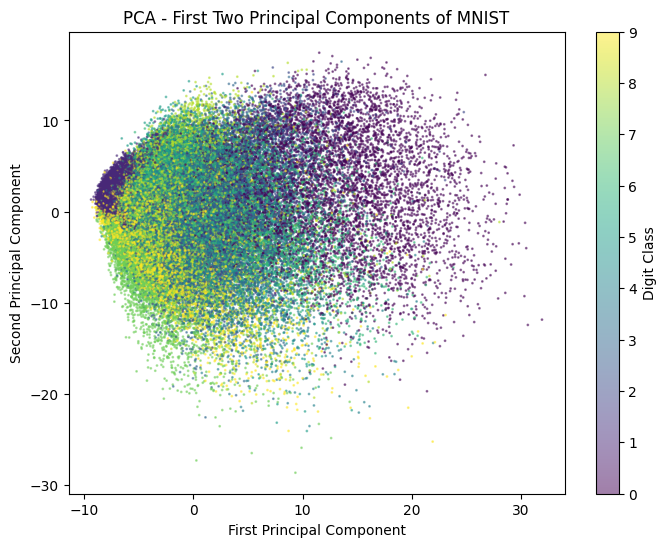

In [84]:
## Visualize the first two principal component
# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=1, alpha=0.5)
plt.colorbar(label='Digit Class')
plt.title('PCA - First Two Principal Components of MNIST')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#Q.8

In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [86]:
## Define Linear Regression Model using Gradient Descent
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history = []

    def fit(self, X, y):
        # Initialize weights and bias
        self.weights = np.zeros(X.shape[1])  # One weight per feature
        self.bias = 0

        # Perform gradient descent
        for i in range(self.n_iterations):
            # Make predictions
            y_pred = self.predict(X)

            # Calculate the cost (Mean Squared Error)
            cost = self.compute_cost(y, y_pred)
            self.cost_history.append(cost)

            # Compute gradients
            dw = (-2/X.shape[0]) * np.dot(X.T, (y - y_pred))  # Gradient for weights
            db = (-2/X.shape[0]) * np.sum(y - y_pred)          # Gradient for bias

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def compute_cost(self, y, y_pred):
        # Compute Mean Squared Error (MSE)
        return np.mean((y - y_pred)**2)

In [87]:
#Generate a simple dataset (e.g., predicting house prices based on square footage)
# Generate simple dataset: House size (in sqft) vs Price (in $1000)
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # Random square footage data (e.g., 0-2k sqft)
y = 4 + 3 * X + np.random.randn(100, 1)  # Price = 4 + 3 * sqft + some noise

# Reshaping y to be a 1D array for compatibility
y = y.flatten()

In [88]:
## Training LMR
# Initialize and train the model using gradient descent
model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
model.fit(X, y)

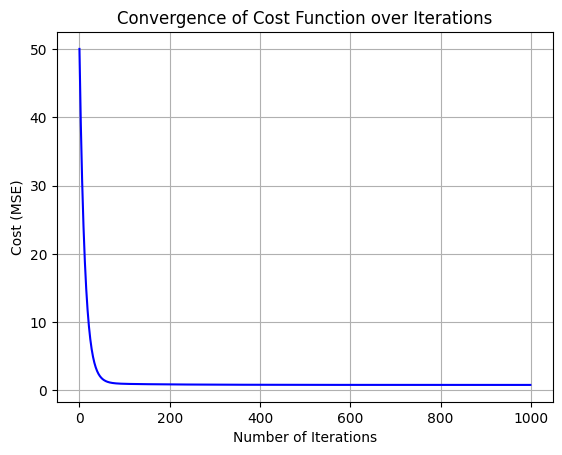

In [90]:
## Plot the cost function convergence
# Plotting the convergence of the cost function
plt.plot(range(model.n_iterations), model.cost_history, color='blue')
plt.title('Convergence of Cost Function over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (MSE)')
plt.grid(True)
plt.show()

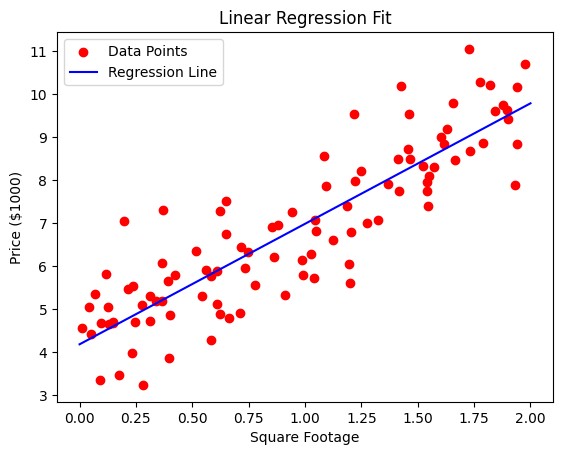

In [92]:
##  Plot the regression line
# Plot the data points
plt.scatter(X, y, color='red', label='Data Points')

# Plot the regression line
X_test = np.linspace(0, 2, 100).reshape(100, 1)
y_test = model.predict(X_test)
plt.plot(X_test, y_test, color='blue', label='Regression Line')

plt.title('Linear Regression Fit')
plt.xlabel('Square Footage')
plt.ylabel('Price ($1000)')
plt.legend()
plt.show()

#Q.9

In [95]:
### Tried accessing boston housing dataset from scikitlearn but during code it shows error that dataset has been
# removed as it contains some outlined and biased data, hence using "California Hosuing DT" dataset.


In [96]:
#Import necessary libarraies
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [101]:
# Z-score normalization (Standardization)
def z_score_normalization(X):
    """Z-score normalization (Standardization)"""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

# Min-Max scaling
def min_max_scaling(X):
    """Min-Max scaling"""
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    return (X - min_val) / (max_val - min_val)


In [102]:
# Load the California Housing dataset
california = fetch_california_housing()
X = california.data
y = california.target

In [103]:
## Apply Z- Score normalization and MIN-MAX scaling
# Apply Z-score normalization
X_zscore = z_score_normalization(X)

# Apply Min-Max scaling
X_minmax = min_max_scaling(X)

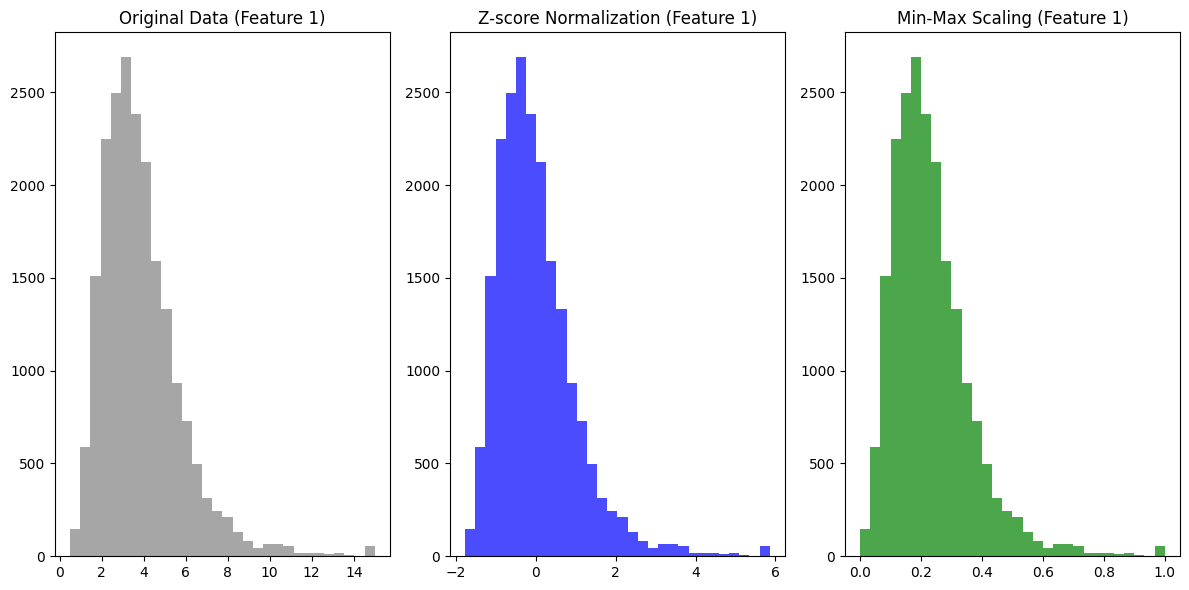

In [104]:
# Plotting the comparison of Z-score normalization and Min-Max scaling
plt.figure(figsize=(12, 6))

# Original data (first feature)
plt.subplot(1, 3, 1)
plt.hist(X[:, 0], bins=30, color='gray', alpha=0.7)
plt.title('Original Data (Feature 1)')

# Z-score normalized data (first feature)
plt.subplot(1, 3, 2)
plt.hist(X_zscore[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Z-score Normalization (Feature 1)')

# Min-Max scaled data (first feature)
plt.subplot(1, 3, 3)
plt.hist(X_minmax[:, 0], bins=30, color='green', alpha=0.7)
plt.title('Min-Max Scaling (Feature 1)')

plt.tight_layout()
plt.show()

#Q.10

In [106]:
## Import libraries
import numpy as np
from sklearn.datasets import load_iris
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [107]:
##  Euclidean Distance Function - We need a function to calculate the Euclidean distance between two data points.
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [108]:
##implement the KNN algorithm. This function will take the training data, test data, and the value of 𝑘
# and predict the labels for the test data.
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Calculate distances from x to all points in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Return the most common class label among the neighbors
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [110]:
##Load and Prepare the Iris Dataset
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [112]:
## Train the KNN Model and Make Predictions
# Initialize the KNN model
k = 3  # User can change this value
knn = KNN(k=k)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Print the predictions and the actual values
print(f"Predicted labels: {y_pred}")
print(f"Actual labels: {y_test}")

Predicted labels: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Actual labels: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]


In [113]:
## Calculate Accuracy of the Model
# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%
